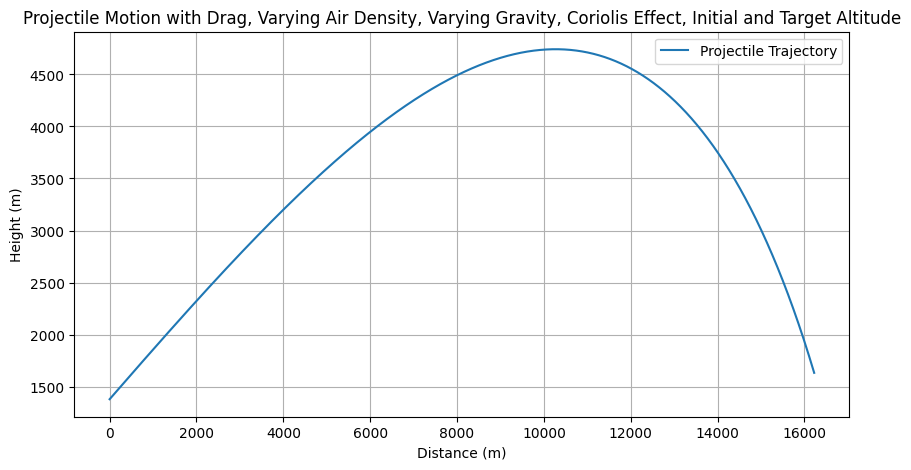

Time of Flight until reaching target altitude: inf seconds
Horizontal Distance traveled until reaching target altitude: 16224.32 meters
Final altitude: 1632.60 meters
Deflection due to Coriolis Effect at target altitude: 0.00 meters


In [3]:
# Here is my artillery Shot data calculations

from numpy import radians, sin, exp, cos, tan
import matplotlib.pyplot as plt
import pandas as pd

# Constants
EARTH_ANGULAR_VELOCITY = 7.2921e-5  # rad/s

# Function to calculate gravitational acceleration with latitude
def gravity_with_latitude(latitude, gp=9.832, alpha=0.0053024):
    latitude_rad = radians(latitude)
    return gp * (1 + alpha * sin(latitude_rad)**2)

# Function to calculate air density with altitude
def air_density_with_altitude(h, rho0=1.225, H=8500):
    return rho0 * exp(-h / H)

# Function to calculate the Coriolis force
def coriolis_force(vx, vy, latitude, azimuth):
    omega = EARTH_ANGULAR_VELOCITY
    latitude_rad = radians(latitude)
    azimuth_rad = radians(azimuth)
    
    # Coriolis acceleration in the east-west direction (x-axis)
    a_coriolis_x = 2 * omega * vy * cos(latitude_rad) * sin(azimuth_rad)
    
    # Coriolis acceleration in the north-south direction (y-axis)
    a_coriolis_y = 2 * omega * (vx * sin(latitude_rad) - vy * cos(latitude_rad) * cos(azimuth_rad))
    
    return a_coriolis_x, a_coriolis_y

# Function to calculate projectile motion with drag, varying air density, varying gravity, and the Coriolis effect
def projectile_motion_with_drag(v0, angle, mass, drag_coefficient, area, latitude, azimuth, initial_altitude, target_altitude):
    # Convert angle to radians
    angle_rad = radians(angle)
    
    # Initial velocity components
    v0x = v0 * cos(angle_rad)
    v0y = v0 * sin(angle_rad)
    # Velocity components
    vx = v0x
    vy = v0y
    
    # Time step for simulation
    dt = 0.01
    t = 0
    x = 0
    y = initial_altitude  # Set the initial altitude
    z = 0  # z-axis for Coriolis effect
    
    # Lists to store the trajectory points
    t_time = []
    x_points = []
    y_points = []
    z_points = []  # z-axis for Coriolis effect
    vx_comp = []
    vy_comp = []
    v_mag = []
    v_qe = []

    # Store the initial points
    t_time.append(t) # seconds
    x_points.append(x) # meters
    y_points.append(y) # meters
    z_points.append(z)  # z-axis for Coriolis effect
    vx_comp.append(v0x) # m/s
    vy_comp.append(v0y) # m/s
    v_mag.append(v0) # m/s
    v_qe.append(angle/180*3200) # trajectory in mils

    
    
    # Calculate the gravitational acceleration for the given latitude
    g = gravity_with_latitude(latitude)
    
    # Simulation loop
    while y >= 0:
        # Calculate the air density at current altitude
        rho = air_density_with_altitude(y)
        
        # Calculate the drag force
        F_drag_x = - (drag_coefficient * rho * area * vx**2) / (2 * mass)
        F_drag_y = - (drag_coefficient * rho * area * vy**2) / (2 * mass)
        
        # Calculate the Coriolis force
        F_coriolis_x, F_coriolis_y = coriolis_force(vx, vy, latitude, azimuth)
        
        # Update velocities
        vx += (F_drag_x + F_coriolis_x) * dt
        vy += (F_drag_y + F_coriolis_y - g) * dt
        
        # Update positions
        t += t + dt
        x += vx * dt
        y += vy * dt
        z += F_coriolis_x * dt  # z-axis for Coriolis effect
        
        # Store the points
        t_time.append(t) # seconds
        x_points.append(x)
        y_points.append(y)
        z_points.append(z)  # z-axis for Coriolis effect
        
        # Check if the projectile has reached the target altitude
        if y <= target_altitude and vy < 0:
            break
        
        # Update time
        t += dt
    
    return t, x, y, z, t_time,x_points, y_points, z_points

# Example usage:
initial_velocity = 682.0
launch_angle = 455.8/3200*180
mass = 103.5/2.2
drag_coefficient = .4244
area = .019
latitude = 32 + 3/60 + 31/3600 # Frankfurt's approximate latitude
azimuth = 145/3200*180 # Firing due east
initial_altitude = 1379 # Launch altitude in meters
target_altitude = 1634 # Target altitude in meters



# Call the function and display the results
time_of_flight, final_x, final_y, final_z, t_time, x_vals, y_vals, z_vals = projectile_motion_with_drag(initial_velocity, launch_angle, mass, drag_coefficient, area, latitude, azimuth, initial_altitude, target_altitude)

shotdata = pd.DataFrame({'t':t_time,'x':x_vals,'y':y_vals,'z':z_vals})
# Plotting the trajectory
plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_vals, label='Projectile Trajectory')
plt.title('Projectile Motion with Drag, Varying Air Density, Varying Gravity, Coriolis Effect, Initial and Target Altitude')
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')
plt.legend()
plt.grid(True)
plt.show()

# Note: The Coriolis effect is represented in the z-axis, which is not plotted in this 2D graph.
print(f"Time of Flight until reaching target altitude: {time_of_flight:.2f} seconds")
print(f"Horizontal Distance traveled until reaching target altitude: {final_x:.2f} meters")
print(f"Final altitude: {final_y:.2f} meters")
print(f"Deflection due to Coriolis Effect at target altitude: {final_z:.2f} meters")
